In [2]:
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
import torch
import os
from dataclasses import dataclass, field
import yaml
from models.autoreg_model import Autoreg_Model
import torch
from types import SimpleNamespace
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as dist
import torch.multiprocessing as mp
import json
from tqdm import tqdm
from functools import partial
import torch.nn as nn
import math
import gpytorch
import torch.optim as optim
@dataclass
class ModelArguments:
    dim_llm_embedding: int = field(default=1024)
    dim_y: int = field(default=1)
    repeat_y: int = field(default=1)
    emb_depth: int = field(default=0)
    d_model: int = field(default=2048)
    dim_feedforward: int = field(default=5120)
    nhead: int = field(default=256)
    dropout: float = field(default=0.2)
    activation: str = field(default="gelu")
    num_layers: int = field(default=4)
    bound_std: bool = field(default=True)
    embed_type: str = field(default="embed_concat")
    uncertainty: str = field(default="normal")
    loss_type: str = field(default="logprob")
    pad_value: float = field(default=0.0)
    context_dim: int = field(default=8)
    action_dim: int = field(default=4)
    gradient_type: str = field(default="std")
    borders_data_dir: str = field(default=None)
        
class LinUCBDisjoint:
    def __init__(self, alpha, d):
        """
        Initializes the LinUCB algorithm with disjoint linear models.

        Args:
            alpha (float): Exploration parameter.
            d (int): Dimension of feature vectors.
        """
        self.alpha = alpha
        self.d = d
        # Using defaultdict to handle new arms dynamically
        self.A = defaultdict(lambda: torch.eye(d))
        self.b = defaultdict(lambda: torch.zeros(d, 1))
        # To store the inverse of A for each arm to save computation
        self.A_inv = defaultdict(lambda: torch.eye(d))
    
    def select_arm(self, feature_matrix):
        """
        Selects the arm with the highest UCB score.

        Args:
            feature_matrix (torch.Tensor): Tensor of shape (num_arms, d) representing features of all arms.

        Returns:
            int: The index of the selected arm.
        """
        num_arms = feature_matrix.size(0)
        p = torch.zeros(num_arms)
        
        for a in range(num_arms):
            x_a = feature_matrix[a].unsqueeze(1)  # Shape: (d, 1)
            theta_a = torch.matmul(self.A_inv[a], self.b[a])  # Shape: (d, 1)
            mean = torch.matmul(theta_a.t(), x_a).item()
            uncertainty = self.alpha * torch.sqrt(torch.matmul(x_a.t(), torch.matmul(self.A_inv[a], x_a))).item()
            p[a] = mean + uncertainty
        
        # Select the arm with the highest p value
        a_t = torch.argmax(p).item()
        return a_t

    def update(self, a_t, x_t, r_t):
        """
        Updates the model parameters for the selected arm.

        Args:
            a_t (int): The index of the selected arm.
            x_t (torch.Tensor): Feature vector of the selected arm, shape (d,).
            r_t (float): Observed reward.
        """
        x_t = x_t.unsqueeze(1)  # Shape: (d, 1)
        self.A[a_t] += torch.matmul(x_t, x_t.t())
        self.b[a_t] += r_t * x_t
        # Update the inverse using the Sherman-Morrison formula for efficiency
        A_inv_a = self.A_inv[a_t]
        x = x_t
        A_inv_x = torch.matmul(A_inv_a, x)  # Shape: (d, 1)
        denominator = 1.0 + torch.matmul(x.t(), A_inv_x)  # Shape: (1, 1)
        numerator = torch.matmul(A_inv_x, A_inv_x.t())  # Shape: (d, d)
        self.A_inv[a_t] = A_inv_a - numerator / denominator

class LinUCBGreedy:
    def __init__(self, alpha, d):
        """
        Initializes the LinUCB algorithm with disjoint linear models.

        Args:
            alpha (float): Exploration parameter.
            d (int): Dimension of feature vectors.
        """
        self.alpha = alpha
        self.d = d
        # Using defaultdict to handle new arms dynamically
        self.A = defaultdict(lambda: torch.eye(d))
        self.b = defaultdict(lambda: torch.zeros(d, 1))
        # To store the inverse of A for each arm to save computation
        self.A_inv = defaultdict(lambda: torch.eye(d))
    
    def select_arm(self, feature_matrix):
        """
        Selects the arm with the highest UCB score.

        Args:
            feature_matrix (torch.Tensor): Tensor of shape (num_arms, d) representing features of all arms.

        Returns:
            int: The index of the selected arm.
        """
        num_arms = feature_matrix.size(0)
        p = torch.zeros(num_arms)
        
        for a in range(num_arms):
            x_a = feature_matrix[a].unsqueeze(1)  # Shape: (d, 1)
            theta_a = torch.matmul(self.A_inv[a], self.b[a])  # Shape: (d, 1)
            mean = torch.matmul(theta_a.t(), x_a).item()
            # uncertainty = self.alpha * torch.sqrt(torch.matmul(x_a.t(), torch.matmul(self.A_inv[a], x_a))).item()
            p[a] = mean 
        
        # Select the arm with the highest p value
        a_t = torch.argmax(p).item()
        return a_t

    def update(self, a_t, x_t, r_t):
        """
        Updates the model parameters for the selected arm.

        Args:
            a_t (int): The index of the selected arm.
            x_t (torch.Tensor): Feature vector of the selected arm, shape (d,).
            r_t (float): Observed reward.
        """
        x_t = x_t.unsqueeze(1)  # Shape: (d, 1)
        self.A[a_t] += torch.matmul(x_t, x_t.t())
        self.b[a_t] += r_t * x_t
        # Update the inverse using the Sherman-Morrison formula for efficiency
        A_inv_a = self.A_inv[a_t]
        x = x_t
        A_inv_x = torch.matmul(A_inv_a, x)  # Shape: (d, 1)
        denominator = 1.0 + torch.matmul(x.t(), A_inv_x)  # Shape: (1, 1)
        numerator = torch.matmul(A_inv_x, A_inv_x.t())  # Shape: (d, d)
        self.A_inv[a_t] = A_inv_a - numerator / denominator

In [3]:
class HyperbolicFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        self.c = nn.Parameter(torch.randn(1))

        self.a.requires_grad = False
        self.b.requires_grad = False
        self.c.requires_grad = False
        
    def forward(self, x):
        return self.a * x**2 + self.b * x + self.c


In [22]:
import torch
import torch.distributions as dist
from types import SimpleNamespace


class TS_machine:
    def __init__(self, uq_model, device, dim_llm_embedding, imagination_horizon):
        self.uq_model = uq_model
        self.device = device
        self.dim_llm_embedding = dim_llm_embedding
        self.imagination_horizon = imagination_horizon
        self.uq_joint_context_x = []
        self.uq_joint_context_y = []
        self.uq_joint_pred_loss = []
        self.uq_joint_actual_rewards = []

    def predict(self, x_t, beta_hat):
        beta_hat = beta_hat.to(self.device)
        x_t = x_t.to(self.device)
        uq_joint_predicted_rewards = torch.matmul(x_t, beta_hat.T)
        return uq_joint_predicted_rewards

    def update_batch(self, x_t, reward_t):
        self.uq_joint_context_x.append(x_t.unsqueeze(0))
        self.uq_joint_context_y.append(torch.tensor(reward_t, device=self.device).unsqueeze(0).unsqueeze(0))
    
    def set_batch(self, x_t, reward_t):
        batch = SimpleNamespace(
        xc=torch.stack(self.uq_joint_context_x, dim=1).repeat(1, 1, 1).to(self.device) if self.uq_joint_context_x else torch.empty(1, 0, self.dim_llm_embedding, device=self.device),
        yc=torch.stack(self.uq_joint_context_y, dim=1).repeat(1, 1, 1).to(self.device) if self.uq_joint_context_y else torch.empty(1, 0, 1, device=self.device),
        xt=x_t,
        yt=torch.zeros(reward_t.shape, device=self.device))

        return batch

    def ts_imagination(self, x_t, reward_t):
        inner_context_x = []
        inner_context_y = []
        uq_joint_batch = self.set_batch(x_t, reward_t)
        dim_llm_embedding = self.dim_llm_embedding
        device = self.device
        uq_model = self.uq_model
        uq_context_x = uq_joint_batch.xc
        uq_context_y = uq_joint_batch.yc
        

        for i in range(self.imagination_horizon):

            # Generate random contexts
            context = torch.randn(1, 1, dim_llm_embedding, device=device)

            inner_xc = torch.cat(inner_context_x, dim=1) if inner_context_x else torch.empty(1, 0, dim_llm_embedding, device=device)
            full_xc = torch.cat([uq_context_x, inner_xc], dim=1) 
            inner_yc = torch.cat(inner_context_y, dim=1) if inner_context_y else torch.empty(1, 0, 1, device=device)
            full_yc = torch.cat([uq_context_y, inner_yc], dim=1) 
            full_xc = full_xc.to(device)
            full_yc = full_yc.to(device)
            batch = SimpleNamespace(
                xc=full_xc,
                yc=full_yc,
                xt=context,  # Shape: num_arms,1, dim_llm_embedding
                yt=torch.zeros(1, 1, 1, device=device)  # Shape: num_arms,1,1
            )

            predicted_rewards = uq_model.predict(batch)
            inner_context_x.append(context)
            inner_context_y.append(predicted_rewards)

        # Concatenate all inner context data
        X = torch.cat(inner_context_x, dim=1)  
        y = torch.cat(inner_context_y, dim=1)  
        X = torch.cat([uq_context_x, X], dim=1)
        y = torch.cat([uq_context_y, y], dim=1)

        return X, y

In [29]:
num_arms = 10
d = 1
img_horizon = 10
device = 'cpu'
uq_config = yaml.load(open('/user/al4263/rlhf/TPU/scripts/ccb_uq_std.yaml', 'r'), Loader=yaml.FullLoader)
# use config to create model arguments
uq_model_args = ModelArguments(**uq_config['model_args'])

uq_models = []
for _ in range(num_arms):
    uq_model = Autoreg_Model(uq_model_args)
    uq_checkpoint_dir = f'/shared/share_mala/Leon/CCB_1/UQ-normal-Gradient-std-Loss-logprob-Horizon-2000_Noise_0.2/model_checkpoint_100.pt'
    uq_model.load_state_dict(torch.load(uq_checkpoint_dir, weights_only=True))
    uq_model.to(device)
    uq_models.append(uq_model)

ts_machine_list = [TS_machine(uq_model, device, d, img_horizon) for uq_model in uq_models]

noise_scale = 0.2
funcs = [HyperbolicFunction() for _ in range(num_arms)]
feature_matrix = torch.randn(num_arms, d)
expected_rewards = torch.tensor([funcs[i](feature_matrix[i]) for i in range(num_arms)])
env_rewards = expected_rewards + torch.randn(expected_rewards.shape) * noise_scale

In [30]:
ts_machine_list[0].uq_joint_context_x = []
ts_machine_list[0].uq_joint_context_y = []
noise_scale = 0.2

for i in range(5):

    feature_matrix = torch.randn(num_arms, d)
    expected_rewards = torch.tensor([funcs[i](feature_matrix[i]) for i in range(num_arms)])
    env_rewards = expected_rewards + torch.randn(expected_rewards.shape) * noise_scale
    a_t = 0
    x_t = feature_matrix[a_t]
    r_t = env_rewards[a_t]
    ts_machine_list[0].update_batch(x_t, r_t.item())

In [31]:
ts_machine = ts_machine_list[0]
X,y = ts_machine.ts_imagination(x_t, r_t)


batch.xc.shape: torch.Size([1, 5, 1])
batch.yc.shape: torch.Size([1, 5, 1])
batch.xt.shape: torch.Size([1, 1, 1])
batch.yt.shape: torch.Size([1, 1, 1])
batch.xc.shape: torch.Size([1, 6, 1])
batch.yc.shape: torch.Size([1, 6, 1])
batch.xt.shape: torch.Size([1, 1, 1])
batch.yt.shape: torch.Size([1, 1, 1])
batch.xc.shape: torch.Size([1, 7, 1])
batch.yc.shape: torch.Size([1, 7, 1])
batch.xt.shape: torch.Size([1, 1, 1])
batch.yt.shape: torch.Size([1, 1, 1])
batch.xc.shape: torch.Size([1, 8, 1])
batch.yc.shape: torch.Size([1, 8, 1])
batch.xt.shape: torch.Size([1, 1, 1])
batch.yt.shape: torch.Size([1, 1, 1])
batch.xc.shape: torch.Size([1, 9, 1])
batch.yc.shape: torch.Size([1, 9, 1])
batch.xt.shape: torch.Size([1, 1, 1])
batch.yt.shape: torch.Size([1, 1, 1])
batch.xc.shape: torch.Size([1, 10, 1])
batch.yc.shape: torch.Size([1, 10, 1])
batch.xt.shape: torch.Size([1, 1, 1])
batch.yt.shape: torch.Size([1, 1, 1])
batch.xc.shape: torch.Size([1, 11, 1])
batch.yc.shape: torch.Size([1, 11, 1])
batch.xt

In [37]:
beta_hat = torch.linalg.lstsq(X.squeeze(0), y.squeeze(0)).solution
print(f'beta_hat.shape: {beta_hat.shape}')

beta_hat.shape: torch.Size([1, 1])


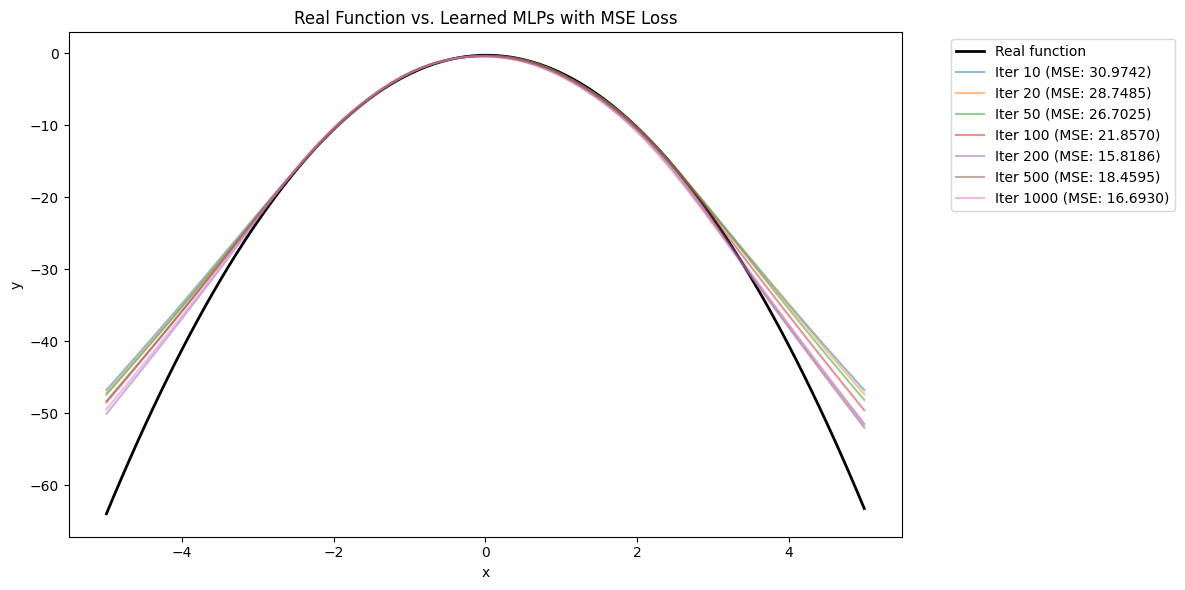

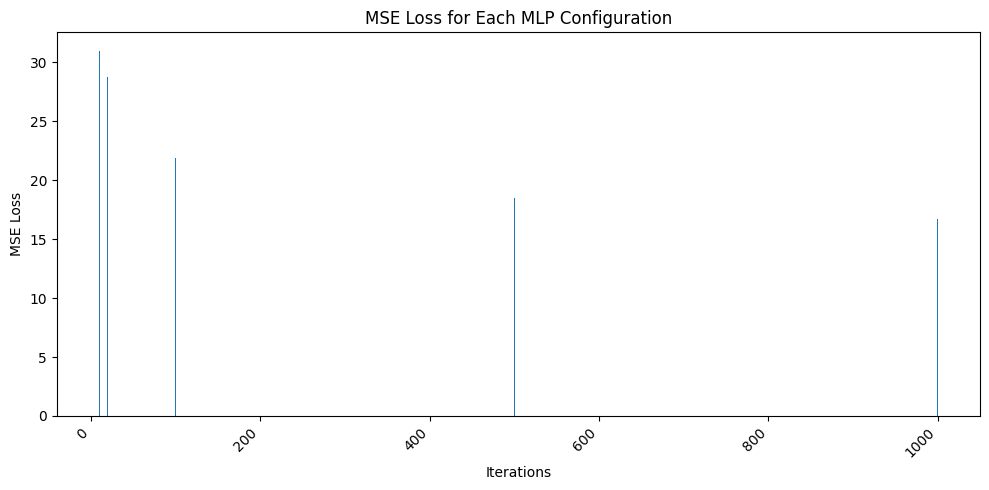

Average MSE Loss: 22.7505
Minimum MSE Loss: 15.8186
Maximum MSE Loss: 30.9742


In [109]:
x = torch.linspace(-5, 5, 100).unsqueeze(-1)
real_y = funcs[0](x).squeeze()

plt.figure(figsize=(12, 6))
plt.plot(x, real_y, label='Real function', linewidth=2, color='black')

mse_losses = []
for iteration, mlp in mlp_list:
    pred_y = mlp(x).squeeze().detach()
    mse_loss = F.mse_loss(pred_y, real_y).item()
    mse_losses.append(mse_loss)
    plt.plot(x, pred_y, label=f'Iter {iteration} (MSE: {mse_loss:.4f})', alpha=0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Real Function vs. Learned MLPs with MSE Loss')
plt.tight_layout()
plt.show()

# Plot MSE losses
plt.figure(figsize=(10, 5))
iterations = [iter for iter, _ in mlp_list]
plt.bar(iterations, mse_losses)
plt.xlabel('Iterations')
plt.ylabel('MSE Loss')
plt.title('MSE Loss for Each MLP Configuration')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Average MSE Loss: {np.mean(mse_losses):.4f}")
print(f"Minimum MSE Loss: {np.min(mse_losses):.4f}")
print(f"Maximum MSE Loss: {np.max(mse_losses):.4f}")

In [91]:
mlp_dict = {}
epoch_list = [100, 500, 1000]
lr_list = [1e-2, 1e-3, 1e-4]
for epoch in epoch_list:
    for lr in lr_list:
        mlp = train_mlp(X, y, epoch, lr)
        mlp_dict[f'epoch_{epoch}_lr_{lr}'] = mlp

# Convert the dictionary to a list for compatibility with the plotting code
mlp_list = list(mlp_dict.values())


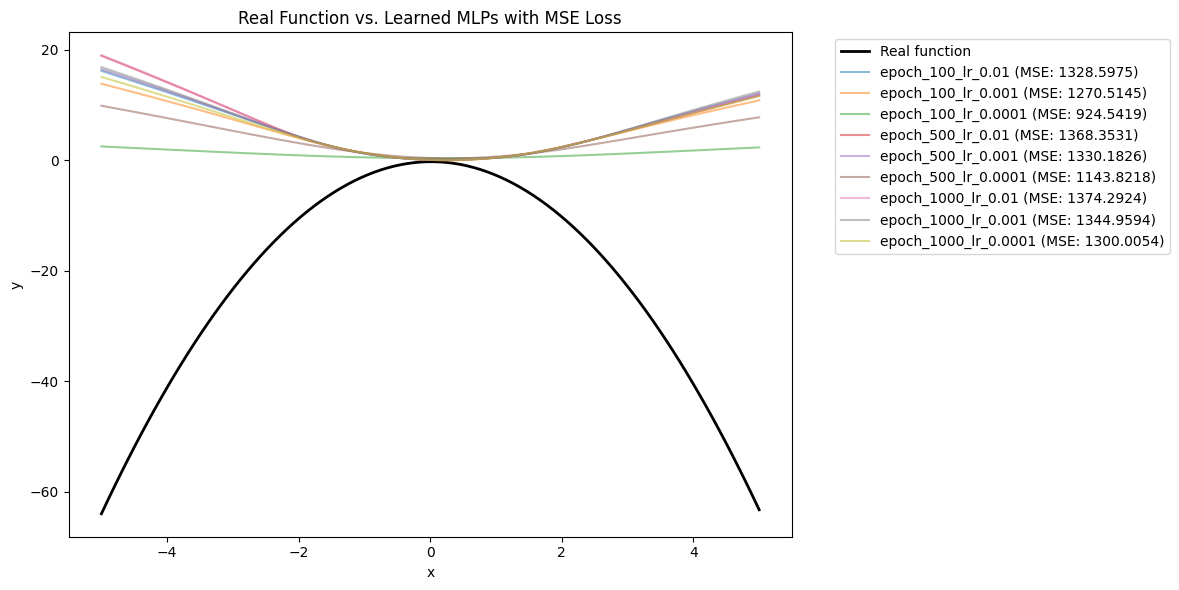

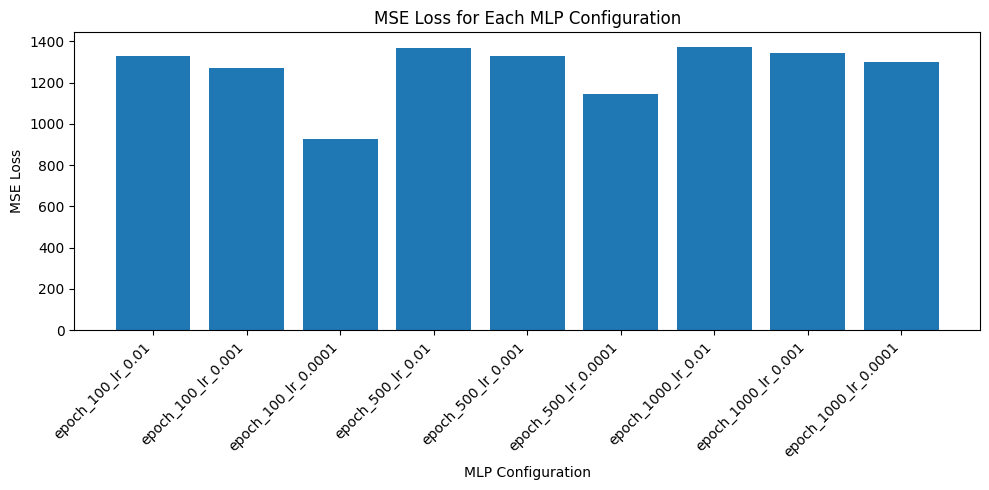

Average MSE Loss: 1265.0298
Minimum MSE Loss: 924.5419
Maximum MSE Loss: 1374.2924


In [108]:
x = torch.linspace(-5, 5, 100).unsqueeze(-1)
real_y = funcs[0](x).squeeze()

plt.figure(figsize=(12, 6))
plt.plot(x, real_y, label='Real function', linewidth=2, color='black')

mse_losses = []
for i, (key, mlp) in enumerate(mlp_dict.items()):
    pred_y = mlp(x).squeeze().detach()
    mse_loss = F.mse_loss(pred_y, real_y).item()
    mse_losses.append(mse_loss)
    plt.plot(x, pred_y, label=f'{key} (MSE: {mse_loss:.4f})', alpha=0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Real Function vs. Learned MLPs with MSE Loss')
plt.tight_layout()
plt.show()

# Plot MSE losses
plt.figure(figsize=(10, 5))
plt.bar(mlp_dict.keys(), mse_losses)
plt.xlabel('MLP Configuration')
plt.ylabel('MSE Loss')
plt.title('MSE Loss for Each MLP Configuration')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Average MSE Loss: {np.mean(mse_losses):.4f}")
print(f"Minimum MSE Loss: {np.min(mse_losses):.4f}")
print(f"Maximum MSE Loss: {np.max(mse_losses):.4f}")